# Projeto 2 - Ciência dos Dados - 2020.2 

### Previsão da demanda em lojas Walmart estadunidenses a fim de evitar o desperdício, maximizando o lucro nesses estabelecimentos

#### Equipe: Andressa Silva de Oliveira; Camila Buzin Ladeira; Luiz Ricardo Hardman; Matheus Kwon

## - Introdução -

### Objetivo:

A habilidade de prever dados de forma exata é extremamente valiosa em uma vasta gama de domínios como saúde, vendas, finanças, clima ou esportes (GIL, 2019). No contexto em questão, a previsão das vendas em lojas Walmart é uma técnica de gestão fundamental, a qual garante a qualidade da produção e evita perdas com estoque, logística e compras, além de servir como base para a tomada de decisões estratégicas. Dessa forma, é fundamental que tais previsões apresentem um alto nível de acurácia, uma vez que interferem diretamente nos resultados obtidos pela empresa, que se baseia nesses valores para estabelecer metas de vendas e definir uma logística funcional (BONOTTO, 2015). 

Objetiva-se, então, desenvolver ao longo deste documento a análise exploratória de uma base de dados acerca das vendas semanais em lojas Walmart estadunidenses, a construção de modelos preditivos baseados em técnicas de regressão e a posterior validação e comparação dos resultados obtidos. Dessa forma, espera-se chegar a um modelo que se adeque melhor à base de dados utilizada, sendo capaz de prever de forma mais precisa as demandas nesses estabelecimentos e contribuindo, então, para a otimização dos processos e maximização dos lucros. 



### Descrição da base de dados:

A base de dados (dataset) utilizada foi obtida por meio da plataforma Kaggle, a qual disponibiliza datasets variados para uso em competições e projetos científicos, e apresenta dados semanais relativos a 45 lojas Walmart estadunidenses ao longo de um período de três anos (entre 2010 e 2012). As variáveis presentes no dataset de interesse, descritas a seguir, são: store, data, weeklysales, holiday, temperature, fuel, cpi e unemployment.

**Variáveis da base de dados Walmart_Store_sales:**

- **store**: representa a numeração da loja representada, 1-45;
- **data**: variável que apresenta dia, mês e ano do dado, respectivamente, representando a semana que as observações foram tomadas;
- **weeklysales** : variável que apresenta a receita de cada loja semanalmente (US\$) (variável de monitoramento);
- **holiday**: variável que representa se a data do dado é feriado ou não (yes/no);
- **temperature** : variável que apresenta a temperatura média da semana na região de  cada loja, em fahrenheit (°F);
- **fuel**: preço do galão de gasolina no dia do dado (US\$);
- **cpi** : variável que representa o preço médio necessário para comprar um conjunto de bens de consumo e serviços num país no dia, comparando com períodos anteriores ( Índice de preços no consumidor )  (US\$);
- **unemployment** : variável que representa a taxa de desemprego durante a semana, na região de cada loja, de zero a um.

Ao longo da análise em questão, serão considerados como **Target** (variável resposta ou dependente), os dados correspondentes à coluna weeklysales, uma vez que objetiva-se prever valores para essa variável quantitativa; e como **Features** (variáveis explicativas ou independentes), os dados correspondentes às demais colunas da base de dados.

Na primeira célula de código, que se encontra abaixo, colocou-se, para fins de organização, os comandos utilizados para importar todas as bibliotecas que foram utilizadas ao longo do desenvolvimento do documento em questão. Cada linha do código importa uma biblioteca distinta, a qual possibilita o uso de diferentes comandos de manipulação e análise de dados.

In [1]:
# Bibliotecas importadas:

import os
import random
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

import statsmodels.api as sm
import seaborn as sns

from sklearn.metrics import mean_squared_error

# Imports para o segundo modelo
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV

## - Minerando Dados e Características do Dataset -

### Mineração:

A primeira etapa, denominada mineração, corresponde à coleta dos dados e, uma vez que todas as informações que serão utilizadas já se encontram no dataset supracitado, tendo-se já adicionado este ao repositório, utilizou-se o código abaixo a fim de garantir que o dataset está sendo reconhecido.

In [2]:
# Código para reconhecimento do dataset:
filename = 'Walmart_Store_sales.xlsx'

if filename in os.listdir():
    print(f'Encontrei o arquivo {filename}, tudo certo!')
else:
    print(f'Não encontrei o arquivo {filename} no diretório {os.getcwd()}')

Encontrei o arquivo Walmart_Store_sales.xlsx, tudo certo!


Em seguida, armazenando a base de dados na variável “data”, plotou-se as cinco primeiras linhas, verificando-se então, o formato do dataset, no qual todos os dados estão em apenas uma coluna e separados por vírgula.

In [3]:
# Código para leitura do dataset:
data = pd.read_excel(filename)
data.head(5)

,"Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment"
0,"1,05-02-2010,1643690.9,0,42.31,2.572,211.09635..."
1,"1,12-02-2010,1641957.44,1,38.51,2.548,211.2421..."
2,"1,19-02-2010,1611968.17,0,39.93,2.514,211.2891..."
3,"1,26-02-2010,1409727.59,0,46.63,2.561,211.3196..."
4,"1,05-03-2010,1554806.68,0,46.5,2.625,211.35014..."


### Análise descritiva detalhada:

Posteriormente, iniciou-se a etapa de limpeza e análise descritiva a fim de compreender as características e relações entre as variáveis do dataset. Para isso, no código abaixo separou-se a coluna única em forma de listas, as quais foram adicionadas como valores em um dicionário cujas chaves são os nomes de cada variável presente no dataset. 

In [4]:
# Manipulação do dataset para fins do projeto

linhas = data['Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment']

dicio = {'store':[], 'date':[], 'weeklysales':[], 'holiday':[], 'temperature':[], 'fuel':[], 'cpi':[], 'unemployment':[]}

# Separação das colunas no dicionário, em forma de listas

for linha in linhas:
    results = linha.split(',')
    i = 0
    for key in dicio.keys():
        variable = results[i]
        if key != 'date' and key != 'store':
            variable = float(results[i])
        dicio[key].append(variable)
        i += 1


Esse dicionário foi, então, transformado em um DataFrame, formato que possibilita o uso de comandos da biblioteca Pandas (criada e amplamente utilizada para análise e manipulação de dados diversos) e facilita a visualização dos dados. Além disso, algumas das suas variáveis foram manipuladas como comentado no código abaixo e, em seguida, plotou-se novamente as primeiras cinco linhas, verificando-se que a manipulação para organização do dataset funcionou como esperado, uma vez que cada variável de interesse passou a se localizar em uma coluna diferente.

In [5]:
# Transformando o dicionário em dataframe:

df = pd.DataFrame()
for key, lista in dicio.items():
    df[key] = pd.Series(lista)
    
# Transformando as variáveis de acordo com o seu tipo:

df.holiday = df.holiday.astype('int') # define a variável holiday como número inteiro
df.store = df.store.astype('category') # define o número da loja como variável qualitativa ordinal
df.date = pd.to_datetime(df.date) # define a variável para datas
df.unemployment = (df.unemployment)/100 # taxa de desemprego(em porcentagem)/100
df.head(5)

,store,date,weeklysales,holiday,temperature,fuel,cpi,unemployment
0,1,2010-05-02,1643690.90,0,42.31,2.572,211.096358,0.08106
1,1,2010-12-02,1641957.44,1,38.51,2.548,211.242170,0.08106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,0.08106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,0.08106
4,1,2010-05-03,1554806.68,0,46.50,2.625,211.350143,0.08106


* #### Análise descritiva detalhada das variáveis weeklysales, temperature, fuel, cpi, unemployment e store:

Após a criação do DataFrame e separação das variáveis em colunas distintas, iniciou-se a análise detalhada das variáveis a fim de compreender o comportamento dessas ao longo do período a que os dados referem-se. Para isso, armazenou-se na variável "df_analise1" as colunas: weeklysales, temperature, fuel, cpi e unemployment do DataFrame e, utilizando-se o comando ".describe()" obteve-se as medidas resumo de tais colunas, como pode ser visto a seguir:

In [6]:
# Análise das variáveis quantitativas

df_analise1 = df[['weeklysales','temperature','fuel','cpi','unemployment']]
df_analise1.describe()

,weeklysales,temperature,fuel,cpi,unemployment
count,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000
mean,1.046965e+06,60.663782,3.358607,171.578394,0.079992
std,5.643666e+05,18.444933,0.459020,39.356712,0.018759
min,2.099862e+05,-2.060000,2.472000,126.064000,0.038790
25%,5.533501e+05,47.460000,2.933000,131.735000,0.068910
50%,9.607460e+05,62.670000,3.445000,182.616521,0.078740
75%,1.420159e+06,74.940000,3.735000,212.743293,0.086220
max,3.818686e+06,100.140000,4.468000,227.232807,0.143130


A obtenção dos parâmetros acima permite a análise de características como a média (mean) de cada variável quantitativa, a qual ilustra o comportamento médio de cada variável levando em conta os dados de todas as lojas ao longo do período analisado, o desvio padrão (std), o qual indica qual o grau de variação entre os dados considerados, alguns quantis notáveis, que indicam até cada porcentagem (25%, 50% e 75%) de dados de cada coluna, em ordem crescente, o valor máximo alcançado por eles, bem como seus valores mínimos e máximos, possibilitando uma análise inicial dos valores como um todo.

Posteriormente, verificou-se se as colunas apresentavam valores indefinidos, os quais geralmente aparecem como "Nan" e podem representar algum erro. Para tal, utilizou-se o código abaixo, o qual percorre as colunas selecionadas anteriormente e devolve a contagem de valores indefinidos e, como pode ser visto a seguir, nenhum valor desse tipo foi encontrado.

In [7]:
# Verificando se há valores indefinidos

df_analise1.isnull().sum()

weeklysales     0
temperature     0
fuel            0
cpi             0
unemployment    0
dtype: int64

Em seguida, a fim de verificar de maneira mais global como a variável de monitoramento (weeklysales) comporta-se ao longo de todo o período analisado, plotou-se um gráfico de dispersão das vendas semanais (eixo y) ao longo do tempo (eixo x), no qual cada dado correspondente a essa variável presente no DataFrame é representado como um ponto em azul, observando-se o comportamento ilustrado a seguir:

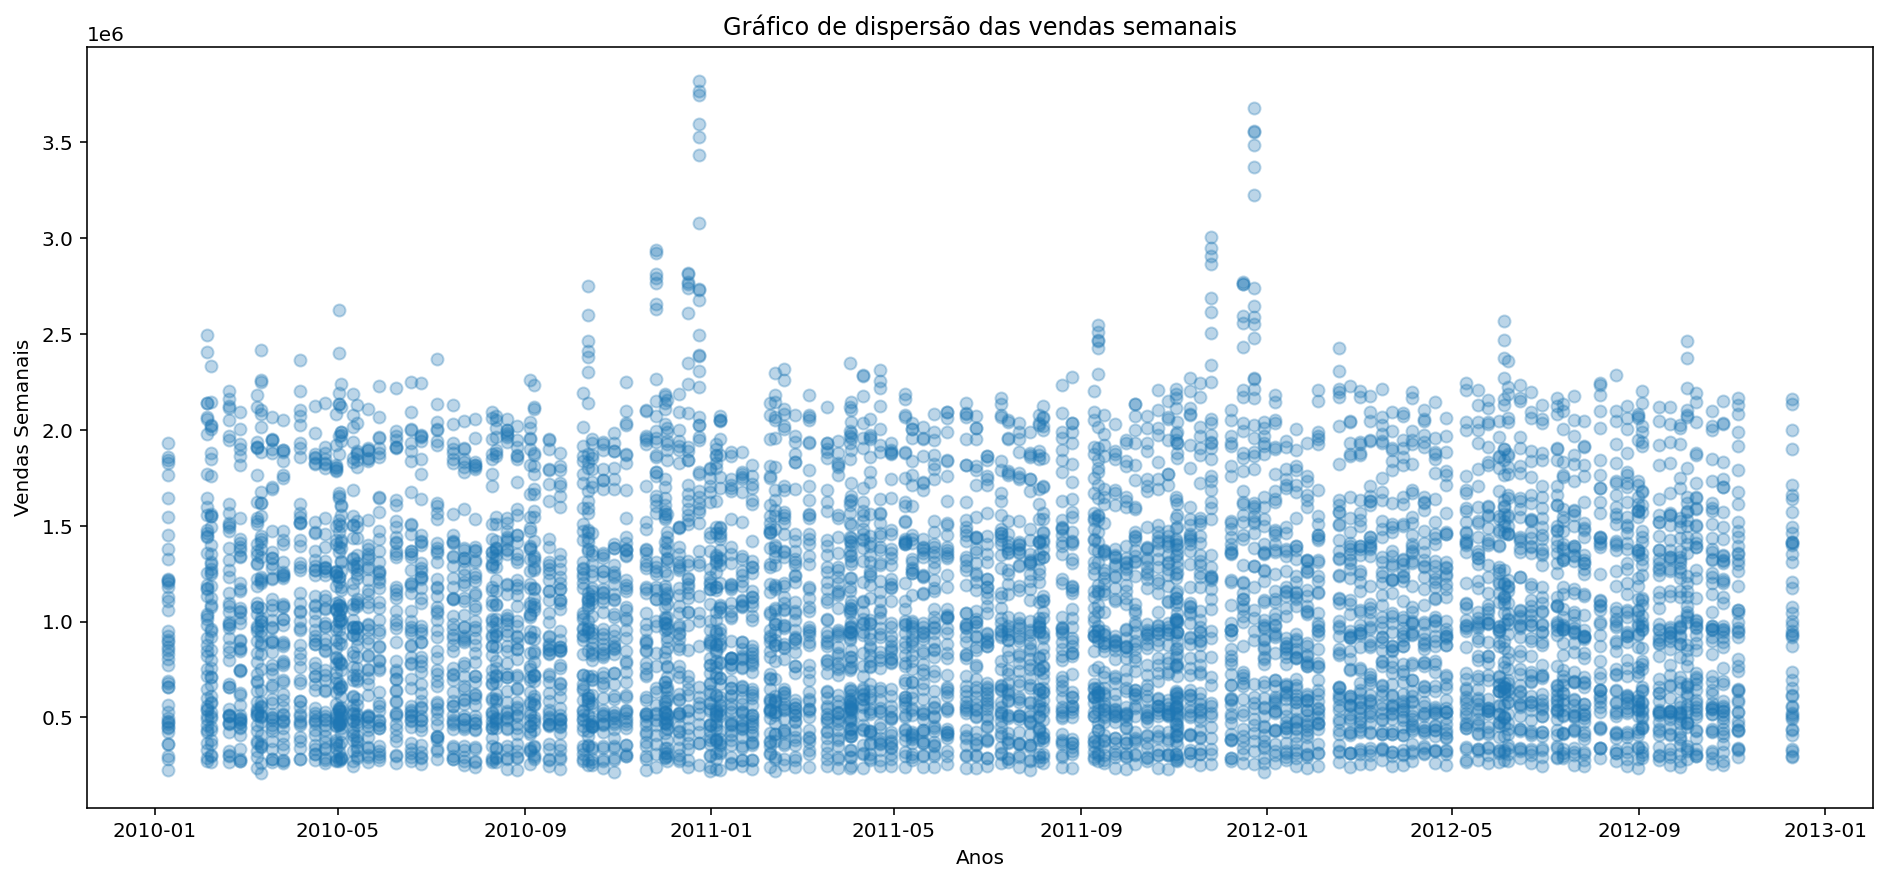

In [8]:
# Gráfico de dispersão das vendas semanais para todas as lojas ao longo do período 2010 a 2012

plt.figure(figsize=(16, 7))
plt.title('Gráfico de dispersão das vendas semanais')
plt.xlabel('Anos')
plt.ylabel('Vendas Semanais')
plt.plot(df.date, df.weeklysales, 'o', alpha=0.3)
plt.show()

* A partir do gráfico acima, percebe-se que nas semanas próximas ao fim de cada ano ocorre, em geral, um aumento nas vendas semanais

Posterioemente, visando analisar de maneira mais particular o comportamento da variável de monitoramento e de cada loja, plotou-se os três gráficos de dispersão ilustrados abaixo. Para isso, utilizou-se a lógica ilustrada na primeira parte do código que segue a fim de permitir que a escolha da loja e do ano a serem plotados seja aleatória, e, em seguida, o código para plotar e configurar os gráficos assim como feito na célula anterior.

Store 11, year 2011


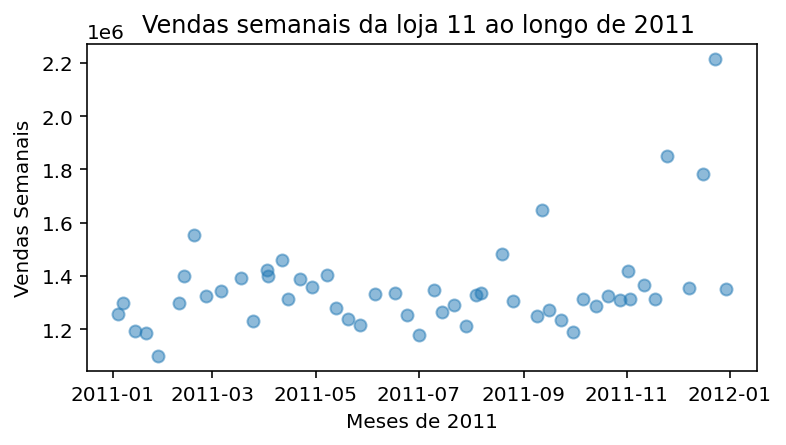

Store 4, year 2010


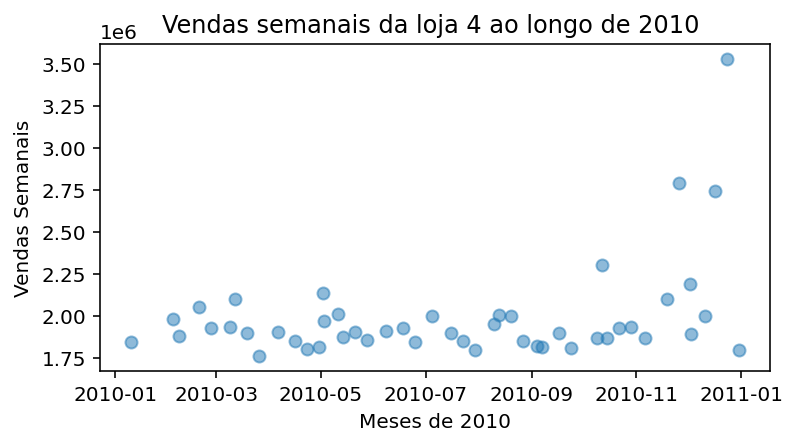

Store 41, year 2012


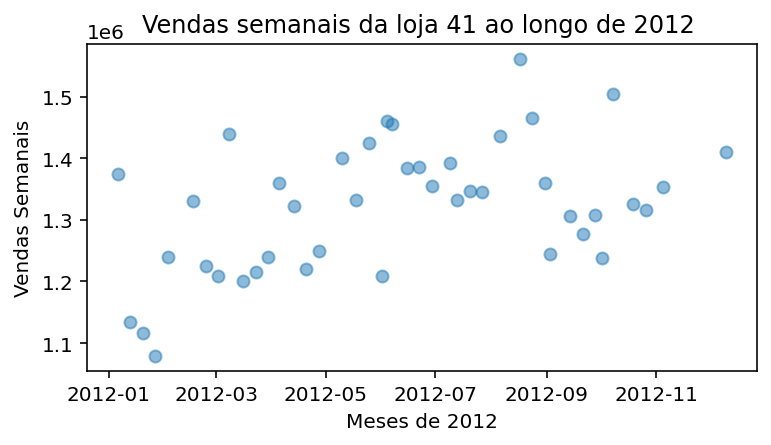

In [9]:
# Gráfico de dispersão das vendas semanais para lojas selecionadas aleatoriamente durante um ano selecionado
# também aleatoriamente

teste_lojas = []
teste_anos = []
for x in range(3):
    
    a = True # loop para não repetir loja e ano
    while a == True:
        n = random.randint(1,45)
        year = random.randint(2010,2012)
        if n not in teste_lojas and year not in teste_anos:
            teste_lojas.append(n)
            teste_anos.append(year)
            a = False
    
    filtroano = []
    for i in df.date:
        if i.year == year:
            filtroano.append(True)
        else:
            filtroano.append(False)
    
    filtrostore = df.store == str(n)
    
    datesano = []
    for i in range(len(df)):
        if df.date[i].year == year and df.store[i] == str(n):
            datesano.append(df.date[i])
    
    salesyear = df.loc[filtroano & filtrostore,'weeklysales']
    
    print(f'Store {n}, year {year}')
    plt.figure(figsize=(6, 3))
    plt.title('Vendas semanais da loja {0} ao longo de {1} '.format(n,year))
    plt.ylabel('Vendas Semanais')
    plt.xlabel('Meses de {0}'.format(year))
    plt.plot(datesano, salesyear,'o', alpha=0.5)
    plt.show()

* Assim como observado no comportamento de todas as lojas juntas, ilustrado no gráfico anterior, percebe-se para cada loja que, em geral, há um aumento nas vendas semanais no período próximo ao final do ano.

* #### Análise descritiva detalhada das variáveis weeklysale e holiday:

Após a análise das variáveis anteriores, iniciou-se a de holiday, que fornece ao dia a característica de ser feriado ou não, o que é indicado pelos valores inteiros 1 ou 0, respectivamente. Para isso, inicialmente utilizou-se o comando abaixo para selecionar, no DataFrame, as linhas de dias que eram feriado, nomeadas como "yes" e as de dias que não o eram, nomeadas como "no", e posteriormente selecionar apenas a coluna weeklysales para cada um desses rótulos com o uso do comando ".loc[]". Após essa seleção, plotou-se as medidas resumo para a variável weeklysales em cada situação, observando-se os resultados abaixo:

In [10]:
# Análise da relação entre as variáveis weeklysales e holiday

no = df.holiday == 0
yes = df.holiday == 1

holiday_no = df.loc[no,["weeklysales"]]
holiday_yes = df.loc[yes,["weeklysales"]]

medidas_resumo_holiday_no = holiday_no.describe()
medidas_resumo_holiday_yes = holiday_yes.describe()

In [11]:
# Medidas resumo para semanas sem feriado

medidas_resumo_holiday_no.round(3)

,weeklysales
count,5985.000
mean,1041256.380
std,558957.436
min,209986.250
25%,551378.390
50%,956211.200
75%,1414343.530
max,3818686.450


In [12]:
# Medidas resumo para semanas com feriado

medidas_resumo_holiday_yes.round(3)

,weeklysales
count,450.000
mean,1122887.892
std,627684.932
min,215359.210
25%,575865.482
50%,1018538.040
75%,1555213.175
max,3004702.330


* Analisando-se as medidas resumo obtidas acima, percebe-se que, quando há feriado, a média das vendas semanais é maior. No entanto, nessas mesmas semanas observa-se também uma variância maior, o que significa que há lojas com vendas bem maiores que outras e também que há feriados em que as vendas são maiores do que em outros.

Plotou-se também os histogramas a seguir a fim de visualizar os valores descritos acima:

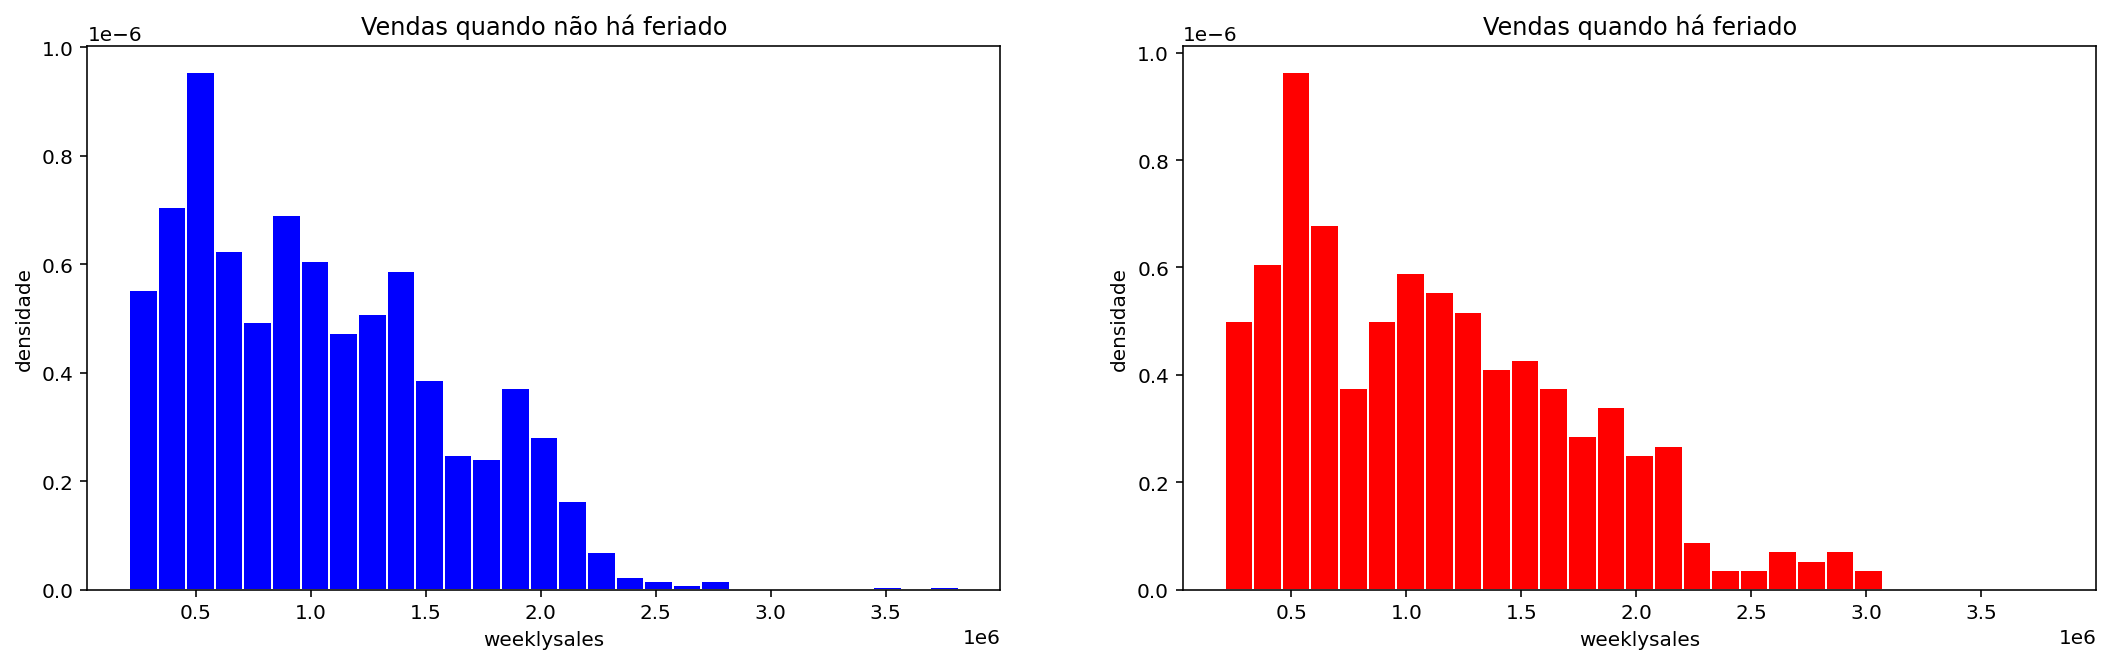

In [13]:
# Análise, em histograma, das vendas semanais para semanas em que não há ou não feriado

faixas = np.linspace(df.weeklysales.min(),df.weeklysales.max(),30)

plt.figure(figsize=(18, 5))

plt.subplot(121)
plt.hist(holiday_no.weeklysales, bins=faixas, density=True, color='blue', edgecolor='white')
plt.ylabel('densidade')
plt.xlabel('weeklysales')
plt.title('Vendas quando não há feriado')

plt.subplot(122)
plt.hist(holiday_yes.weeklysales, bins=faixas, density=True, color='red', edgecolor='white')
plt.ylabel('densidade')
plt.xlabel('weeklysales')
plt.title('Vendas quando há feriado')

plt.show()

* #### Análise geral das relações entre weeklysales e as demais variáveis

Tendo-se realizado as analises detalhadas acima, plotou-se os gráficos a seguir a fim de relacionar o target às demais features, obtendo-se os comportamentos ilustrados a seguir:

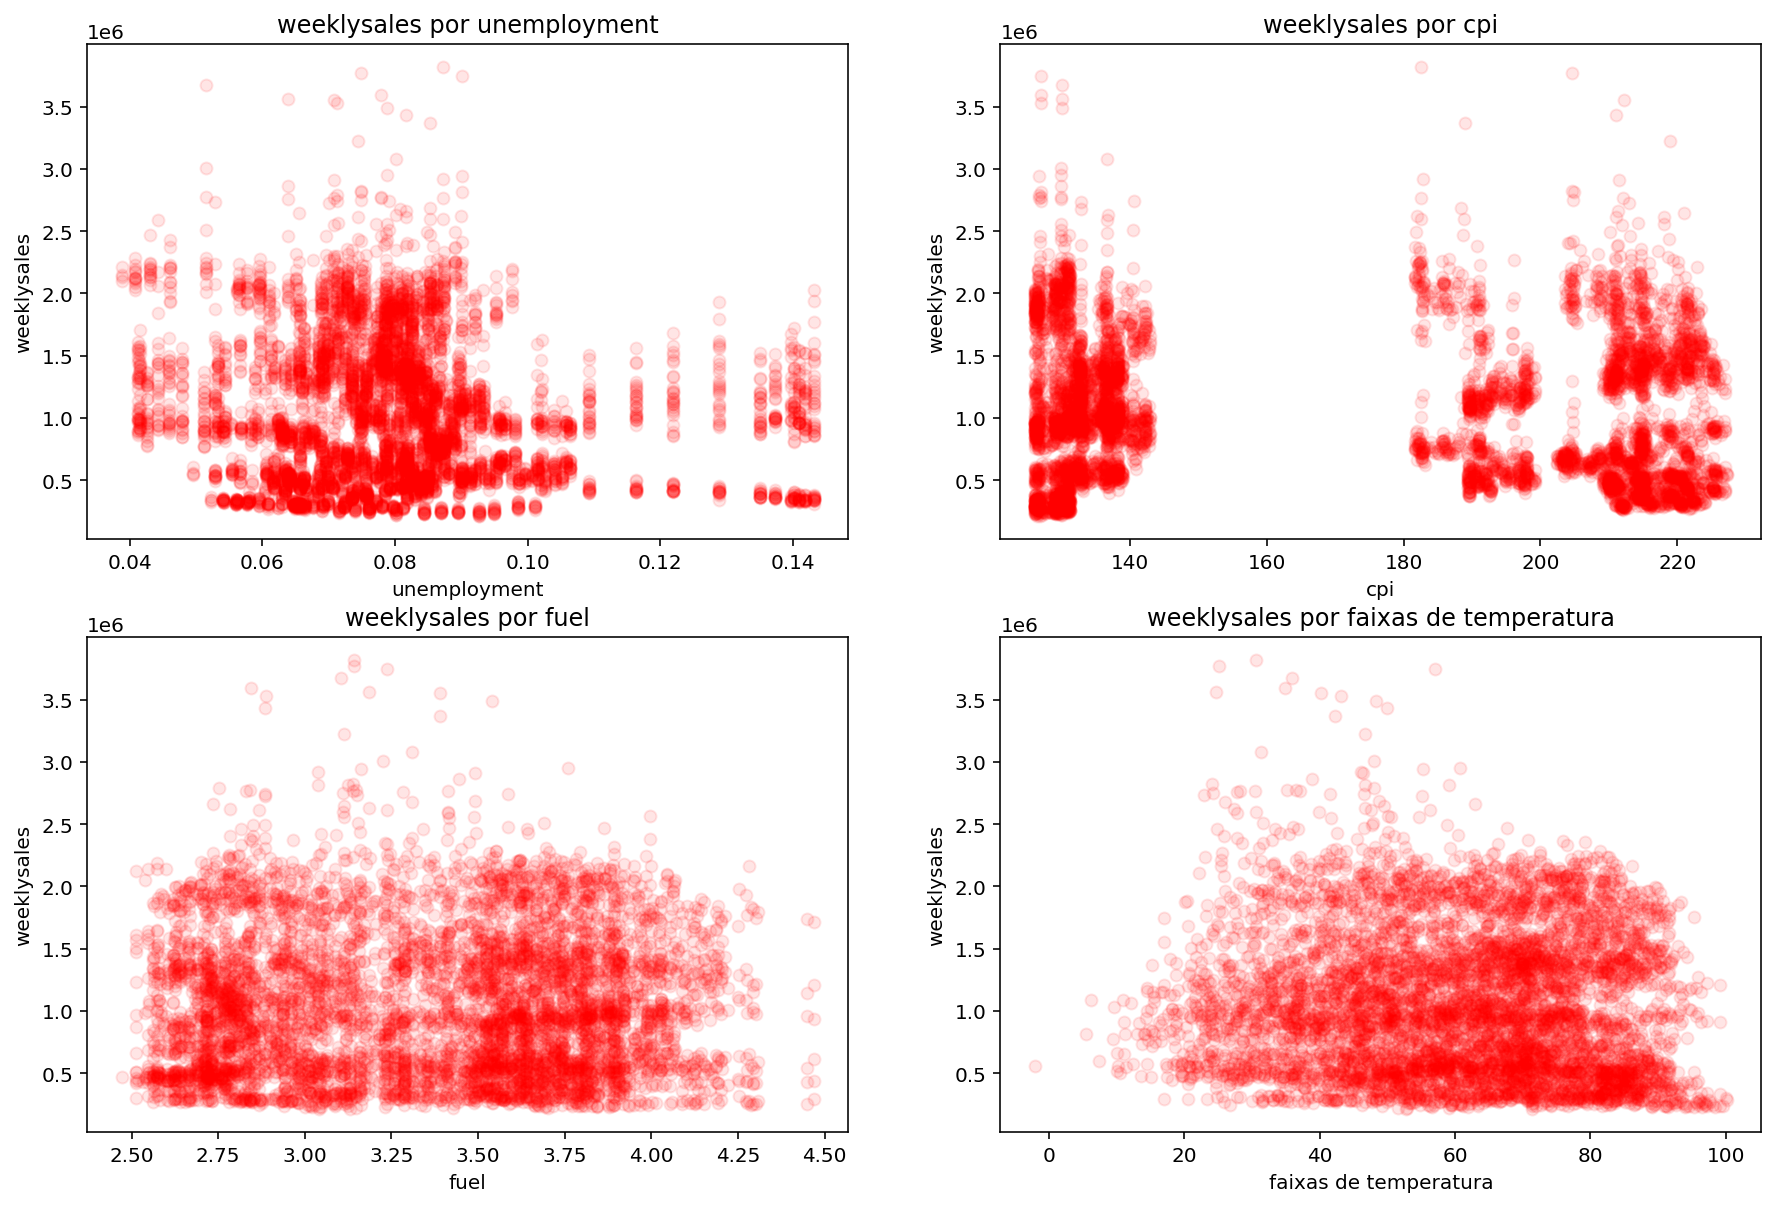

In [14]:
fig = plt.figure(figsize=(15,10))

# weeklysales com unemployment
plt.subplot(221)
plt.scatter(df.unemployment, df.weeklysales, c='red', alpha=0.1)
plt.title('weeklysales por unemployment')
plt.ylabel('weeklysales')
plt.xlabel('unemployment')

# weeklysales com cpi
plt.subplot(222)
plt.scatter(df.cpi, df.weeklysales, c='red', alpha=0.1)
plt.title('weeklysales por cpi')
plt.ylabel('weeklysales')
plt.xlabel('cpi')

# weeklysales com fuel
plt.subplot(223)
plt.scatter(df.fuel, df.weeklysales, c='red', alpha=0.1)
plt.title('weeklysales por fuel')
plt.ylabel('weeklysales')
plt.xlabel('fuel')

# weeklysales com temperature
plt.subplot(224)
plt.scatter(df.temperature, df.weeklysales, c='red', alpha=0.1)
plt.title('weeklysales por faixas de temperatura')
plt.ylabel('weeklysales')
plt.xlabel('faixas de temperatura')

plt.show()

A análise desses gráficos não permite nenhuma conclusão específica, uma vez que mesmo os dados estando agrupados não há um comportamento típico de crescimento ou descrescimento que levem à conclusão de que há uma relação positiva ou negativa, respectivamente. Dessa forma, a fim de verificar se os formatos acima permitem a percepção de alguma relação não visível apenas graficamente utilizou-se os comandos abaixo para plotar os valores de correlação, que indicam pelo seu sinal se as realações entre as variáveis é positiva ou negativa; e pelo seu valor, se são fortes ou fracas.

In [20]:
# Correlações referentes às variáveis ilustradas nos gráficos acima

nomes = ['unemployment','cpi', 'fuel', 'temperature','holiday']
dfs = [df.unemployment, df.cpi, df.fuel, df.temperature, df.holiday]
for i in range(len(nomes)):
    print('Correlação entre {0} e weeklysales é: {1}'.format(nomes[i], df.weeklysales.corr(dfs[i])))

Correlação entre unemployment e weeklysales é: -0.10617608965795428
Correlação entre cpi e weeklysales é: -0.07263416204017631
Correlação entre fuel e weeklysales é: 0.009463786314475123
Correlação entre temperature e weeklysales é: -0.0638100131794696
Correlação entre holiday e weeklysales é: 0.03689096801041456


* As correlações mostram, então, uma baixa relação entre as features ilustradas e o target, uma vez que os valores obtidos são pequenos. Sendo assim, faz-se também uma análise de múltiplas features de forma conjunta utilizando-se o comando abaixo, o qual permite relacionar weeklysales a todas as demais variáveis de uma vez.

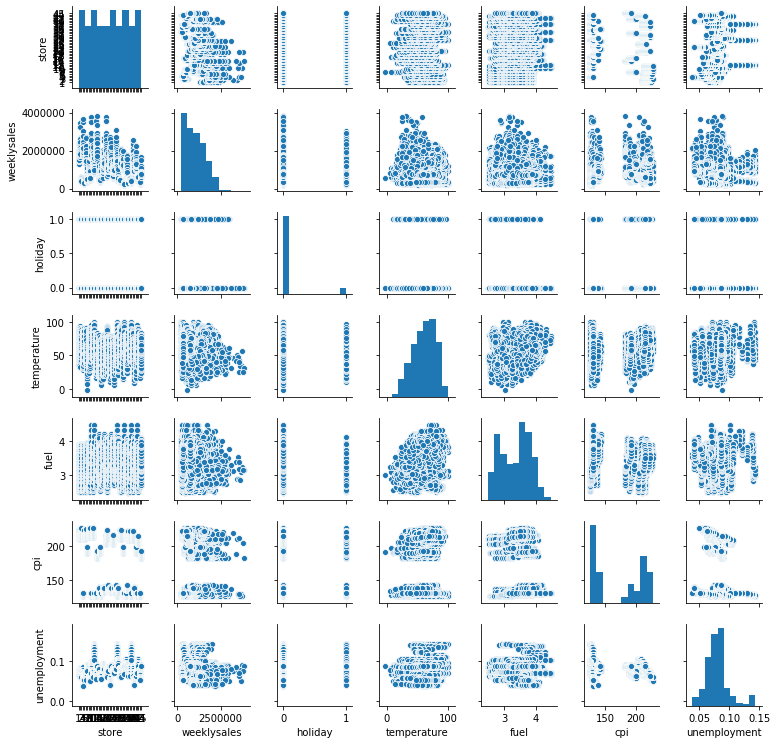

In [21]:
# Pairplot com as combinações de todas as variáveis quantitativas envolvidas

sns.pairplot(df, height=1.5);

* Percebe-se novamente, a partir dos gráficos acima, que não há nenhuma relação clara entre as variáveis, o que condiz com as análises feitas anteriormente.

## - Modelos de Predição -

* ### Separação da base de dados em conjuntos de treinamento e teste:

Após observar o comportamento da variável target em função das features selecionadas, percebeu-se que não parecia haver muita correlação entre cada feature individualmente e as vendas semanais, por isso, como primeiro modelo de inferência da variável de interesse, foi escolhida a regressão linear múltipla, na qual considera-se mais de uma feature para a previsão da target - função linear para cada feature.

Além disso, parece razoável também monitorar as vendas semanais para cada mês do ano e para cada ano diferente. Por isso, foram adicionadas as features mês e ano de cada dado, a partir da variável de data já existente.


In [22]:
x = df.date.dt.year
df['year'] = pd.Series(x)
y = df.date.dt.month
df['month'] = pd.Series(y)
df

df.year = df.year.astype('int')
df.month = df.month.astype('int')

Verificando os tipos de variáveis da base de dados:

In [23]:
df.dtypes

store                 category
date            datetime64[ns]
weeklysales            float64
holiday                  int32
temperature            float64
fuel                   float64
cpi                    float64
unemployment           float64
year                     int32
month                    int32
dtype: object

Embaralhou-se todos os dados e foram selecionados os primeiros 75% deles para o treinamento e o restante foi deixado para teste:


In [24]:
df_shuffle = df.sample(frac = 1) 
df_treinamento = df_shuffle.head(int(len(df)*(0.75)+1))
df_teste = df_shuffle.tail(int(len(df)*(0.25)))

Observando se os dois conjuntos estão com as devidas quantidades de dados:

In [25]:
df_treinamento

,store,date,weeklysales,holiday,temperature,fuel,cpi,unemployment,year,month
5700,40,2012-06-15,977950.28,0,63.39,3.683,138.129533,0.04125,2012,6
570,4,2012-10-19,2097266.85,0,64.46,3.610,131.149968,0.03879,2012,10
3083,22,2011-08-19,973004.91,0,71.30,3.820,140.128920,0.08023,2011,8
2829,20,2012-03-30,2074721.74,0,51.52,3.953,214.164708,0.06961,2012,3
1291,10,2010-05-03,1987090.09,0,55.92,2.877,126.578286,0.09765,2010,5
...,...,...,...,...,...,...,...,...,...,...
4375,31,2011-09-23,1347607.74,0,75.68,3.467,216.028236,0.07852,2011,9
2088,15,2011-09-30,521297.31,0,64.87,3.858,136.419500,0.07806,2011,9
4604,33,2010-08-20,230519.49,0,96.46,3.041,126.076645,0.09495,2010,8
4121,29,2012-04-05,504963.84,0,50.75,3.991,138.033200,0.09140,2012,4


In [26]:
df_teste

,store,date,weeklysales,holiday,temperature,fuel,cpi,unemployment,year,month
4113,29,2012-09-03,504750.35,0,41.72,3.876,137.506690,0.08988,2012,9
6002,42,2012-05-10,593162.53,0,80.88,4.132,131.075667,0.06943,2012,5
3378,24,2011-10-21,1283563.43,0,56.60,3.757,136.501774,0.08454,2011,10
5858,41,2012-09-28,1307928.01,0,56.08,3.789,198.590328,0.06432,2012,9
1179,9,2010-08-10,505069.21,0,65.35,2.633,215.290437,0.06560,2010,8
...,...,...,...,...,...,...,...,...,...,...
157,2,2010-05-14,1880752.36,0,73.31,2.854,209.998458,0.08200,2010,5
3819,27,2012-01-13,1492399.13,0,41.30,3.666,140.704821,0.08009,2012,1
4454,32,2010-02-07,1187988.64,0,74.74,2.728,189.488260,0.09017,2010,2
2551,18,2012-05-25,1088446.58,0,65.48,3.850,138.110194,0.08304,2012,5


### 1° modelo: Modelo de Regressão Linear Múltipla

* Hipóteses:

**$α = 0,1\%$**

**H0: não há relação entre weeklysales e a variável analisada - $β = 0$** $\Rightarrow$ probabilidades acima de $α$

**H1: há relação entre weeklysales e a variável analisada - $β ≠ 0$** $\Rightarrow$ probabilidades abaixo de $α$

Para iniciar o modelo de regressão linear múltipla, utilizou-se como features as variáveis quantitativas de temperatura (temperature), de preço da gasolina (fuel), de índice de preços no consumidor (cpi) e de taxa de desemprego (unemployment) e as variáveis qualitativas de feriado (holiday), de ano (year) e de mês (month), que foram quantificadas em números para o modelo, além da variável target de vendas semanais (weeklysales).

In [0]:
# Regressão linear múltipla para a combinação weeklysales com holiday, temperature, fuel, cpi, unemployment, year e
# month; todas as variáveis quantitativas.

x = df_treinamento[['holiday','temperature','fuel','cpi','unemployment', 'year', 'month']]
y = df_treinamento['weeklysales']

Então, pelo método dos mínimos quadrados do modelo de regressão OLS, da biblioteca statsmodels, verificou-se a probabilidade de cada feature estar realmente associada à variação de weeklysales.

In [27]:
xc = sm.add_constant(x)
model = sm.OLS(y,xc)
results = model.fit()
results.summary()

C:\Users\Dell\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            weeklysales   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     20.70
Date:                Mon, 23 Nov 2020   Prob (F-statistic):           1.31e-27
Time:                        11:40:20   Log-Likelihood:                -70686.
No. Observations:                4827   AIC:                         1.414e+05
Df Residuals:                    4819   BIC:                         1.414e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.233e+08   3.63e+07      3.399      0.001    5.22e+07    1.94e+08
holiday       2.491e+04   3.38e+04      0.737      0.461   -4.14e+04    9.12e+04
temperature  -1335.2737    466.309     -2.863      0.004   -2249.452    -421.096
fuel          8.931e+04   3.13e+04      2.852      0.004    2.79e+04    1.51e+05
cpi          -1215.9741    233.271     -5.213      0.000   -1673.293    -758.655
unemployment -4.263e+06   4.71e+05     -9.045      0.000   -5.19e+06   -3.34e+06
year         -6.065e+04   1.81e+04     -3.355      0.001   -9.61e+04   -2.52e+04
month         9382.0087   2618.683      3.583      0.000    4248.195    1.45e+04
==============================================================================
Omnibus:                      278.810   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              329.132
Skew:                           0.640   Prob(JB):                     3.39e-72
Kurtosis:                       3.006   Cond. No.                     9.18e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.18e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* A probabilidade de |t| de holiday é muito maior do que o alpha adotado, então, como H0 não é rejeitado, conclui-se que não há relação significativa para o modelo entre weeklysales e holiday.

In [28]:
# Regressão linear múltipla para a combinação weeklysales com temperature, fuel, cpi, unemployment, year e month

x = df_treinamento[['temperature','fuel','cpi','unemployment', 'year', 'month']]
y = df_treinamento['weeklysales']

xc = sm.add_constant(x)
model = sm.OLS(y,xc)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            weeklysales   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     24.06
Date:                Mon, 23 Nov 2020   Prob (F-statistic):           3.31e-28
Time:                        11:40:20   Log-Likelihood:                -70686.
No. Observations:                4827   AIC:                         1.414e+05
Df Residuals:                    4820   BIC:                         1.414e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.217e+08   3.62e+07      3.362      0.001    5.07e+07    1.93e+08
temperature  -1394.0190    459.417     -3.034      0.002   -2294.685    -493.353
fuel          8.775e+04   3.12e+04      2.808      0.005    2.65e+04    1.49e+05
cpi          -1214.3405    233.250     -5.206      0.000   -1671.617    -757.064
unemployment -4.245e+06   4.71e+05     -9.019      0.000   -5.17e+06   -3.32e+06
year         -5.987e+04    1.8e+04     -3.318      0.001   -9.53e+04   -2.45e+04
month         1.006e+04   2450.420      4.106      0.000    5258.134    1.49e+04
==============================================================================
Omnibus:                      279.359   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              329.901
Skew:                           0.640   Prob(JB):                     2.31e-72
Kurtosis:                       3.001   Cond. No.                     9.16e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.16e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* A probabilidade de |t| de fuel é relativamente alta, então, a variável é desconsiderada da inferência.

In [29]:
# Regressão linear múltipla para a combinação weeklysales com temperature, cpi, unemployment, year e month

x = df_treinamento[['temperature', 'cpi','unemployment', 'year', 'month']]
y = df_treinamento['weeklysales']

xc = sm.add_constant(x)
model = sm.OLS(y,xc)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            weeklysales   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     27.25
Date:                Mon, 23 Nov 2020   Prob (F-statistic):           2.76e-27
Time:                        11:40:20   Log-Likelihood:                -70690.
No. Observations:                4827   AIC:                         1.414e+05
Df Residuals:                    4821   BIC:                         1.414e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3.907e+07   2.11e+07      1.851      0.064    -2.3e+06    8.04e+07
temperature  -1126.1517    449.726     -2.504      0.012   -2007.821    -244.483
cpi          -1447.1886    218.171     -6.633      0.000   -1874.903   -1019.474
unemployment -4.068e+06   4.67e+05     -8.716      0.000   -4.98e+06   -3.15e+06
year         -1.862e+04   1.05e+04     -1.775      0.076   -3.92e+04    1942.221
month         1.071e+04   2441.309      4.387      0.000    5922.933    1.55e+04
==============================================================================
Omnibus:                      280.483   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              331.407
Skew:                           0.642   Prob(JB):                     1.09e-72
Kurtosis:                       3.015   Cond. No.                     5.34e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.34e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* A probabilidade de |t| de year é maior do que o alpha adotado, então, como H0 não é rejeitado, conclui-se que não há relação significativa para o modelo entre weeklysales e year

In [30]:
# Regressão linear múltipla para a combinação weeklysales com cpi e unemployment

x = df_treinamento[['temperature', 'cpi','unemployment', 'month']]
y = df_treinamento['weeklysales']

xc = sm.add_constant(x)
model = sm.OLS(y,xc)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            weeklysales   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     33.26
Date:                Mon, 23 Nov 2020   Prob (F-statistic):           2.08e-27
Time:                        11:40:21   Log-Likelihood:                -70691.
No. Observations:                4827   AIC:                         1.414e+05
Df Residuals:                    4822   BIC:                         1.414e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.605e+06   6.19e+04     25.947      0.000    1.48e+06    1.73e+06
temperature  -1211.3316    447.259     -2.708      0.007   -2088.164    -334.499
cpi          -1440.4996    218.187     -6.602      0.000   -1868.246   -1012.753
unemployment -3.864e+06   4.52e+05     -8.540      0.000   -4.75e+06   -2.98e+06
month         1.133e+04   2416.278      4.691      0.000    6597.643    1.61e+04
==============================================================================
Omnibus:                      284.019   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              336.235
Skew:                           0.646   Prob(JB):                     9.72e-74
Kurtosis:                       3.027   Cond. No.                     1.06e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
# Regressão linear múltipla para a combinação weeklysales com cpi, unemployment e month

x = df_treinamento[['cpi','unemployment', 'month']]
y = df_treinamento['weeklysales']

xc = sm.add_constant(x)
model = sm.OLS(y,xc)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            weeklysales   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     41.85
Date:                Mon, 23 Nov 2020   Prob (F-statistic):           1.09e-26
Time:                        11:40:21   Log-Likelihood:                -70695.
No. Observations:                4827   AIC:                         1.414e+05
Df Residuals:                    4823   BIC:                         1.414e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.573e+06   6.07e+04     25.892      0.000    1.45e+06    1.69e+06
cpi          -1563.3934    213.557     -7.321      0.000   -1982.062   -1144.725
unemployment -4.075e+06   4.46e+05     -9.138      0.000   -4.95e+06    -3.2e+06
month         1.084e+04   2410.973      4.496      0.000    6114.295    1.56e+04
==============================================================================
Omnibus:                      285.818   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              338.168
Skew:                           0.647   Prob(JB):                     3.70e-74
Kurtosis:                       3.094   Cond. No.                     9.89e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.89e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Pelos resultados obtidos por esse modelo, apenas as variáveis cpi, unemployment e month foram suficientes para descrever weeklysales. Então, resta apenas verificar as suposições do modelo de regressão linear: a distribuição dos resíduos - diferença entre os valores reais de vendas semanais e os previstos - segue uma distribuição normal e há a presença de homocedasticidade no modelo.

* Verificando as suposições do modelo de regressão linear

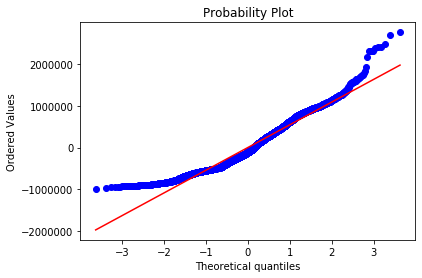

In [33]:
# Verificando a suposição de que os erros têm distribuição Normal

stats.probplot(results.resid, dist='norm', plot=plt);

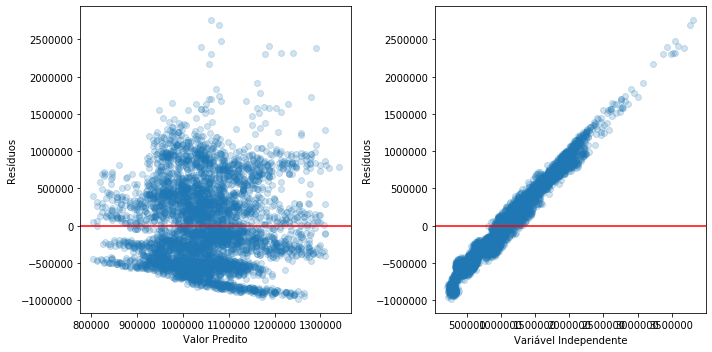

In [34]:
# Verificando a suposição de homocedasticidade:

fig = plt.figure(figsize = (10,5))

plt.subplot(121)
plt.scatter(results.predict(xc), results.resid, alpha=0.2);
plt.axhline(y = 0, color = 'r', linestyle = '-');
plt.ylabel('Resíduos')
plt.xlabel('Valor Predito')

plt.subplot(122)
plt.scatter(y, results.resid, alpha=0.2);
plt.axhline(y = 0, color = 'r', linestyle = '-'); # o valor da variável aleatórias está correto ?
plt.ylabel('Resíduos')
plt.xlabel('Variável Independente')

plt.tight_layout()
plt.show()

* Como evidenciado nos gráficos acima, as hipóteses do modelo não são seguidas. Dessa forma, afim de tentar ajustá-las, utilizou-se a escala logarítmica como ilustrado abaixo:

In [35]:
# Retira valores abaixo de 0

filtrotemperature1 = df_treinamento.temperature > 0
df_treinamento_log = df_treinamento.loc[filtrotemperature1,:]

filtrotemperature2 = df_teste.temperature > 0
df_teste_log = df_teste.loc[filtrotemperature2,:]

In [36]:
# Alterando a escala para log

df_treinamento_log.weeklysales = np.log(df_treinamento_log.weeklysales)
df_treinamento_log.temperature = np.log(df_treinamento_log.temperature)
df_treinamento_log.fuel = np.log(df_treinamento_log.fuel)
df_treinamento_log.cpi = np.log(df_treinamento_log.cpi)
df_treinamento_log.unemployment = np.log(df_treinamento_log.unemployment*100)
df_treinamento_log.month = np.log(df_treinamento_log.month)
df_treinamento_log.year = np.log(df_treinamento_log.year)
df_treinamento_log

C:\Users\Dell\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,store,date,weeklysales,holiday,temperature,fuel,cpi,unemployment,year,month
5700,40,2012-06-15,13.793214,0,4.149306,1.303728,4.928192,1.417066,7.606885,1.791759
570,4,2012-10-19,14.556146,0,4.166045,1.283708,4.876341,1.355577,7.606885,2.302585
3083,22,2011-08-19,13.788144,0,4.266896,1.340250,4.942563,2.082312,7.606387,2.079442
2829,20,2012-03-30,14.545338,0,3.941970,1.374475,5.366745,1.940323,7.606885,1.098612
1291,10,2010-05-03,14.502182,0,4.023922,1.056748,4.840861,2.278805,7.605890,1.609438
...,...,...,...,...,...,...,...,...,...,...
4375,31,2011-09-23,14.113842,0,4.326514,1.243290,5.375409,2.060768,7.606387,2.197225
2088,15,2011-09-30,13.164076,0,4.172385,1.350149,4.915735,2.054893,7.606387,2.197225
4604,33,2010-08-20,12.348091,0,4.569128,1.112186,4.836890,2.250765,7.605890,2.079442
4121,29,2012-04-05,13.132242,0,3.926912,1.384042,4.927494,2.212660,7.606885,1.386294


In [37]:
df_teste_log.weeklysales = np.log(df_teste_log.weeklysales)
df_teste_log.temperature = np.log(df_teste_log.temperature)
df_teste_log.fuel = np.log(df_teste_log.fuel)
df_teste_log.cpi = np.log(df_teste_log.cpi)
df_teste_log.unemployment = np.log(df_teste_log.unemployment*100)
df_teste_log.month = np.log(df_teste_log.month)
df_teste_log.year = np.log(df_teste_log.year)
df_teste_log

,store,date,weeklysales,holiday,temperature,fuel,cpi,unemployment,year,month
4113,29,2012-09-03,13.131819,0,3.730981,1.354804,4.923673,2.195890,7.606885,2.197225
6002,42,2012-05-10,13.293224,0,4.392967,1.418762,4.875775,1.937734,7.606885,1.609438
3378,24,2011-10-21,14.065151,0,4.036009,1.323621,4.916338,2.134640,7.606387,2.302585
5858,41,2012-09-28,14.083955,0,4.026779,1.332102,5.291244,1.861286,7.606885,2.197225
1179,9,2010-08-10,13.132451,0,4.179757,0.968124,5.371988,1.880991,7.605890,2.079442
...,...,...,...,...,...,...,...,...,...,...
157,2,2010-05-14,14.447182,0,4.294697,1.048722,5.347100,2.104134,7.605890,1.609438
3819,27,2012-01-13,14.215896,0,3.720862,1.299101,4.946664,2.080566,7.606885,0.000000
4454,32,2010-02-07,13.987772,0,4.314015,1.003569,5.244327,2.199112,7.605890,0.693147
2551,18,2012-05-25,13.900262,0,4.181745,1.348073,4.928052,2.116737,7.606885,1.609438


In [38]:
df_analise2 = df_treinamento_log[['weeklysales','temperature','fuel','cpi','unemployment', 'year', 'month']]
df_analise2.describe()

,weeklysales,temperature,fuel,cpi,unemployment,year,month
count,4826.000000,4826.000000,4826.000000,4826.000000,4826.000000,4826.000000,4826.000000
mean,13.705981,4.046672,1.202651,5.119206,2.053920,7.606372,1.684805
std,0.583239,0.364375,0.139223,0.231975,0.225187,0.000396,0.682775
min,12.254797,1.829376,0.921477,4.836790,1.355577,7.605890,0.000000
25%,13.230986,3.858886,1.076707,4.881838,1.930216,7.605890,1.386294
50%,13.779107,4.139079,1.238954,5.208376,2.066356,7.606387,1.791759
75%,14.163437,4.314450,1.317748,5.359195,2.153533,7.606885,2.197225
max,15.155417,4.606569,1.496941,5.425975,2.661168,7.606885,2.484907


In [39]:
# Verificando se há valores indefinidos

df_analise2.isnull().sum()

weeklysales     0
temperature     0
fuel            0
cpi             0
unemployment    0
year            0
month           0
dtype: int64

Refazendo o modelo a partir da variáveis em escala logarítmica:

In [40]:
logx =  df_treinamento_log[['temperature','fuel','cpi','unemployment', 'month', 'year']]
logy = df_treinamento_log['weeklysales']

logxc = sm.add_constant(logx)
logmodel = sm.OLS(logy,logxc)
logresults = logmodel.fit()
logresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            weeklysales   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     18.08
Date:                Mon, 23 Nov 2020   Prob (F-statistic):           7.31e-21
Time:                        11:40:23   Log-Likelihood:                -4191.6
No. Observations:                4826   AIC:                             8397.
Df Residuals:                    4819   BIC:                             8443.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          915.6802    294.762      3.107      0.002     337.811    1493.549
temperature     -0.1157      0.024     -4.755      0.000      -0.163      -0.068
fuel             0.3463      0.109      3.172      0.002       0.132       0.560
cpi             -0.1692      0.040     -4.200      0.000      -0.248      -0.090
unemployment    -0.2558      0.040     -6.327      0.000      -0.335      -0.177
month            0.0382      0.013      3.026      0.002       0.013       0.063
year          -118.4001     38.769     -3.054      0.002    -194.406     -42.394
==============================================================================
Omnibus:                      417.590   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              193.654
Skew:                          -0.307   Prob(JB):                     8.88e-43
Kurtosis:                       2.235   Cond. No.                     3.75e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.75e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
logx =  df_treinamento_log[['temperature', 'cpi','unemployment', 'month']]
logy = df_treinamento_log['weeklysales']

logxc = sm.add_constant(logx)
logmodel = sm.OLS(logy,logxc)
logresults = logmodel.fit()
logresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            weeklysales   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     24.41
Date:                Mon, 23 Nov 2020   Prob (F-statistic):           4.96e-20
Time:                        11:40:23   Log-Likelihood:                -4196.9
No. Observations:                4826   AIC:                             8404.
Df Residuals:                    4821   BIC:                             8436.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           15.6174      0.227     68.723      0.000      15.172      16.063
temperature     -0.1034      0.024     -4.355      0.000      -0.150      -0.057
cpi             -0.2148      0.038     -5.710      0.000      -0.288      -0.141
unemployment    -0.2284      0.039     -5.932      0.000      -0.304      -0.153
month            0.0449      0.012      3.625      0.000       0.021       0.069
==============================================================================
Omnibus:                      405.482   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              191.269
Skew:                          -0.307   Prob(JB):                     2.93e-42
Kurtosis:                       2.242   Cond. No.                         197.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* Verificando as suposições do modelo de regressão linear em escala logarítmica

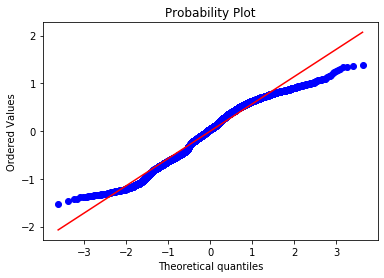

In [43]:
# Verificando a suposição de que os erros têm distribuição Normal

stats.probplot(logresults.resid, dist='norm', plot=plt);

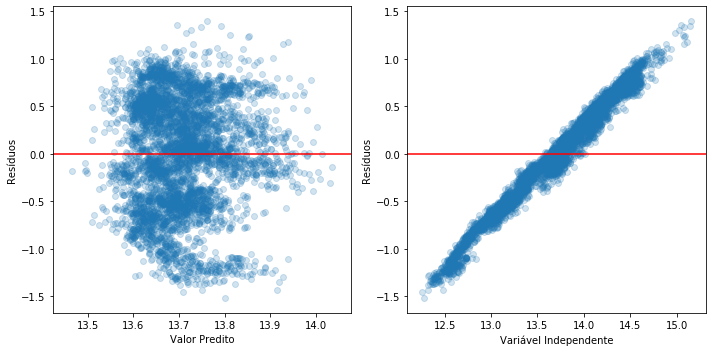

In [44]:
# Verificando a suposição de homocedasticidade na escala log:

fig = plt.figure(figsize = (10,5))

plt.subplot(121)
plt.scatter(logresults.predict(logxc), logresults.resid, alpha=0.2);
plt.axhline(y = 0, color = 'r', linestyle = '-');
plt.ylabel('Resíduos')
plt.xlabel('Valor Predito')

plt.subplot(122)
plt.scatter(logy, logresults.resid, alpha=0.2); # o valor da variável aleatórias está correto ?
plt.axhline(y = 0, color = 'r', linestyle = '-');
plt.ylabel('Resíduos')
plt.xlabel('Variável Independente')

plt.tight_layout()
plt.show()

### Modelo 2: Random Forest Regression

Iniciou-se modelo 2 retirando do DataFrame as series das variáveis que não fossem ser utilizadas como
feature. 
    $\rarr$ Retiramos além da variável target e a serie date pois o seu tipo não condiz com o modelo. 

In [43]:

columns = df.columns.drop(['weeklysales', 'date'])
columns

Index(['store', 'holiday', 'temperature', 'fuel', 'cpi', 'unemployment',
       'year', 'month'],
      dtype='object')

Então dividiu-se o dataset em treinamento e teste. Onde se tem uma quantidade dividida tanto para features quanto para teste, resultando em 4 divisões. Para realizar esse split utilizou-se o comando train_test_split, que tomou como parâmetros as features, target e a porcentagem que gostaríamos de dividir para teste ( 25 % do dataset )

In [44]:
X_train, X_test, y_train, y_test = train_test_split(df[columns],df['weeklysales'], test_size=0.25)

Na célula seguinte foi definido o modelo que será utilizado nas predições das execuções seguintes. 

In [16]:
tree_rf = RandomForestRegressor()

Assim foi introduzido na biblioteca do modelo escolhido os dados de treinamento, antes definidos. Para que assim a biblioteca possa entender e trabalhar com os dados como random regression.

E em seguida utilizando o conhecimento do modelo sobre os dados de treinamento, utilizou-se o método de predição no target de teste, para que fosse possível analisar a performance do modelo. 

In [17]:
model_rf = tree_rf.fit(X_train, y_train)

resultado_rf = model_rf.predict(X_test)

NameError: name 'X_train' is not defined

Com as predições definidas calculamos a média dos erros quadráticos sob as features que foram preditas em relação as corretas. ( O erro foi computado em dollares)

In [18]:
mean_squared_error(y_test, resultado_rf)

NameError: name 'y_test' is not defined

Posteriormente foi computado a porcentagem de acertos do modelo em relação aos testes. Percebemos que foi um valor razoável para a modelagem, mas que poderia ser melhorado. 

In [48]:
model_rf.score(X_test,y_test)

0.936207580183603

Para melhorar os resultados do modelo Random forest implementou-se hiperparâmetros ao longo dos códigos a seguir. 

Começou-se com a definição de um dicionário de parâmetros que tem como intuito definir de forma mais igualitária dos parâmetros ao longo das árvores de decisão. Assim foi definido um valor mínimo de amostras a ser testado no nível folha da árvore, quanto de amostra deve ir para cada árvore e quantas árvores seriam. Desse modo nenhum árvore fica sobrecarregada e as features são bem distribuidas.

In [50]:
parametros = {'min_samples_leaf':[1,10],'min_samples_split':[2,10],'n_estimators':[100,250,500,750]} # parâmetros que queremos ajustar para melhorar

# valores mínimos de amostras para serem testadas na folha da árvore // valores mínimos de amostras para fazer a divisão do módulo interno, ajuda em deixar o modelo mais fluido. // árvores de decisão

Com os parâmetros definidos utilizou-se a função GridSearchCV que tem como função realizar um mutirão de testes exaustivamente, testando e retornando , a partir dos parâmetros sugeridos, os melhores parâmetros dentre os testados para serem usados na implementação do modelo para a base de dados.

In [51]:
rf = RandomForestRegressor() # qual regressão vou usar 
grid = GridSearchCV(rf, parametros)

Assim utilizou-se a função antes descreita na base de treinamento 

In [52]:
grid.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'min_samples_leaf': [1, 10

In [53]:
grid.best_params_

{'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 750}

Com os melhores parâmetros decididos e com o modelo entendendo quem são, assim buscamos os melhores estimadores (variável rf_best) e buscamos assim a melhor redição que o modelo poderia retornar para a base de dados (resultado final $\rarr$ rf_best.predict(X_test))

In [54]:
rf_best = grid.best_estimator_
resultado_final = rf_best.predict(X_test)
resultado_treinamento = rf_best.predict(X_train)

Com o modelo melhorado e desenolvido buscamos qual seria a média dos erros quadráticos para as melhores predições. Mostrando uma melhora com o erro diminuindo 

In [55]:
mean_squared_error(y_test, resultado_final)

20808233974.013016

Assim também buscou-se o score para o modelo final e chegou-se a uma porcentagem de acerto do modelo melhor que a anterior, mostrando um avanço na analise. 

In [20]:
rf_best.score(X_test,y_test)

NameError: name 'rf_best' is not defined

Por fim analizou-se os valores preditos para teste da variável target pelo modelo final de Random Forest Regression. 

In [57]:
rf_best.predict(X_test)

array([1354966.14679156, 1514110.17567674, 1479000.00693075, ...,
        782964.33831476,  856400.6525812 , 1091173.97267882])

## - Processo e Estatísticas de Validação -

A fim de validar os modelos de predição, achou-se importante a análise quanto a correlação entre os dados de teste e a previsão feita pelos modelos, viabilizando a utilização da medida $R^2$. Somado à tal análise, também foi realizada uma observação no tocante ao erro, utilizando a medida RMSE (Raiz do erro quadrático médio). 

A medida  $R^2$ é calculada por meio da seguinte fórmula: $R^2= 1 - \frac {Variações inexplicáveis} {Variação Total}$. Sendo assim, tem-se que esse parâmetro tem seus valores contidos em um intervalo de 0 até 1, sendo valores maiores que 0,85, representantes de uma forte correlação entre as variáveis de teste e a prevista pelo modelo. 
Já a medida RMSE, é calculada por meio da seguinte fórmula: $\sqrt{\frac{\displaystyle\sum\cdot e^2}{n}}$,
sendo e, o erro, n a quantidade de valores contidas na base de testes. 

Portanto, quanto menor é o parâmetro RMSE, melhor é para a validação do modelo.


Função que calcula o $R^2$ da previsão do modelo pelos dados experimentais

In [45]:

def r_squared(dados, modelo):
    numerador = 0
    denominador = 0
    for i in range(len(modelo)):
        numerador += (dados[i]-modelo[i])**2
        denominador += (dados[i]-np.mean(dados))**2
    return 1 - numerador/denominador

##### Validação do modelo 1: Regressão Linear Múltipla

Função que prevê, dados os features, um valor para weeklysales

In [46]:
beta0_1 = results.params[0]
beta1_1 = results.params[1]
beta2_1 = results.params[2]
beta3_1 = results.params[3]

def f_modelo1(feature1, feature2, feature3):
    return beta0_1 + beta1_1*feature1 + beta2_1*feature2 + beta3_1*feature3

treinamento_1 = df_treinamento.weeklysales
predicoes_1_t = f_modelo1(df_treinamento.cpi, df_treinamento.unemployment, df_treinamento.month)
teste_1 = df_teste.weeklysales
predicoes_1 = f_modelo1(df_teste.cpi, df_teste.unemployment, df_teste.month)

Raiz do erro quadrático médio do modelo 1(RMS): 560501.72094


Calcula-se o RMSE nesta célula abaixo

In [0]:
# RMSE no treinamento
soma = 0
for resid in results.resid:
    soma += resid**2
RMSE_modelo1_t = np.sqrt(soma/len(df_treinamento))
print(f'RMSE do modelo 1 (treinamento): {RMSE_modelo1_t:.5f}')

In [0]:
# RMSE no teste
residuos_1 = teste_1 - predicoes_1 #lista de residuos
soma = 0
for resid in residuos_1:
    soma += resid**2
RMSE_modelo1 = np.sqrt(soma/len(df_teste))
print(f'RMSE do modelo 1 (teste): {RMSE_modelo1:.5f}')

Utilizando a função de $R^2$ acima descrita, obtém-se o valor para o modelo 1

In [0]:
# r^2 entre o modelo previsto e os dados treinamento
r_sqr_1_t = r_squared(list(treinamento_1),list(predicoes_1_t))
print(f'r^2 do modelo 1 (treinamento): {r_sqr_1_t:.5f}')

In [47]:
# r^2 entre o modelo previsto e os dados teste
r_sqr_1 = r_squared(list(teste_1),list(predicoes_1))
print(f'r^2 do modelo 1 (teste): {r_sqr_1:.5f}')

r quadrado do modelo 1: 0.03484


 Plotou-se um gráfico, o qual mostra a venda semanal das semanas e lojas  contidas na base de testes e a venda semanal média prevista pelo modelo

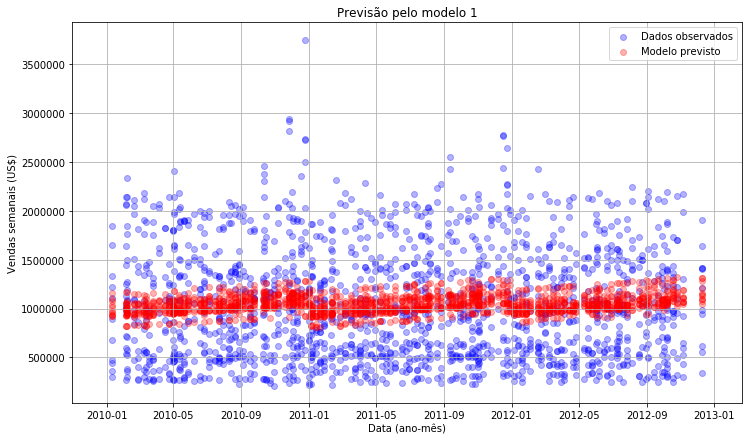

In [56]:
y_teste = df_teste.weeklysales
y_previsto = f_modelo1(df_teste.cpi, df_teste.unemployment, df_teste.month)
x = df_teste.date

plt.figure(figsize=(12,7))
plt.title('Previsão pelo modelo 1')
plt.scatter(x, y_teste, alpha='0.3', color='blue', label='Dados observados')
plt.scatter(x, y_previsto, alpha='0.3', color='red', label='Modelo previsto')
plt.xlabel('Data (ano-mês)')
plt.ylabel('Vendas semanais (US$)')
plt.legend()
plt.grid(True)
plt.show()

Para validar o modelo 1 de regressão linear múltipla, primeiro plotou-se um gráfico, o qual mostra a venda semanal das semanas e lojas  contidas na base de testes e a venda semanal média prevista pelo modelo.


Após isso, calculou-se o RMSE, o qual deu bastante alto, comprovando o que é visto no gráfico. Já em relação ao parâmetro R2, atestou-se também um valor bastante baixo de correlação.


Apesar desses resultados comprovaram que o modelo 1 é bastante falho, pode-se compreender o porquê dessa discrepância. Isso acontece, pois esse mesmo modelo não foi treinado por loja e sim, considerando as features de todas as lojas. Isso retorna então um valor target médio. 


##### Validação do modelo 1 com escala logarítmica

Função que prevê, dados os features, um valor para weeklysales

In [50]:
beta0_1_log = logresults.params[0]
beta1_1_log = logresults.params[1]
beta2_1_log = logresults.params[2]
beta3_1_log = logresults.params[3]
beta4_1_log = logresults.params[4]

def f_modelo1_log(feature1, feature2, feature3, feature4): # função que prevê, dados os features, um valor previsto para weeklysales
    return beta0_1_log + beta1_1_log*feature1 + beta2_1_log*feature2 + beta3_1_log*feature3 + beta4_1_log*feature4

treinamento_1_log = df_treinamento_log.weeklysales
predicoes_1_log_t = f_modelo1_log(df_treinamento_log.temperature, df_treinamento_log.cpi, df_treinamento_log.unemployment, df_treinamento_log.month)
teste_1_log = df_teste_log.weeklysales
predicoes_1_log = f_modelo1_log(df_teste_log.temperature, df_teste_log.cpi, df_teste_log.unemployment, df_teste_log.month)

Raiz do erro quadrático médio do modelo 1 com escala logarítmica (RMS): 0.59623


Calcula-se o RMSE nesta célula abaixo

In [0]:
# RMSE (log) no treinamento
soma = 0
for resid in logresults.resid:
    soma += resid**2
RMSE_modelo1_log_t = np.sqrt(soma/len(df_treinamento_log))
print(f'RMSE do modelo 1 com escala logarítmica (treinamento): {RMSE_modelo1_log_t:.5f}')

In [0]:
# RMSE (log) no teste
residuos_1_log = teste_1_log - predicoes_1_log #lista de residuos
soma = 0
for resid in residuos_1_log:
    soma += resid**2
RMS_modelo1_log = np.sqrt(soma/len(df_teste_log))
print(f'RMSE do modelo 1 com escala logarítmica (teste): {RMS_modelo1_log:.5f}')

Utilizando a função de $R^2$ acima descrita, obtém-se o valor para o modelo 1 em escala log

In [0]:
# r^2 entre o modelo previsto e os dados treinamento
r_sqr_1_log_t = r_squared(list(treinamento_1_log),list(predicoes_1_log_t))
print(f'r^2 do modelo 1 com escala logarítmica: {r_sqr_1_log_t:.5f}')

In [51]:
# r^2 entre o modelo previsto e os dados teste
r_sqr_1_log = r_squared(list(teste_1_log),list(predicoes_1_log))
print(f'r^2 do modelo 1 com escala logarítmica: {r_sqr_1_log:.5f}')

r quadrado do modelo 1 com escala logarítmica: 0.02280


 Plota-se um gráfico, o qual mostra a venda semanal das semanas e lojas  contidas na base de testes e a venda semanal média prevista pelo modelo

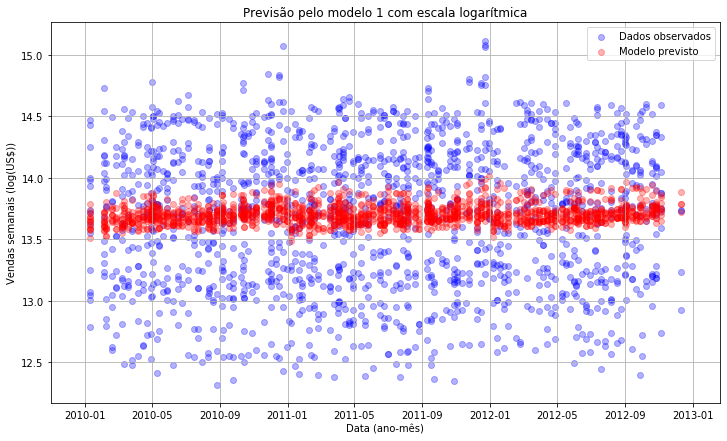

In [64]:
y_teste_log = df_teste_log.weeklysales
y_previsto_log = f_modelo1_log(df_teste_log.temperature, df_teste_log.cpi, df_teste_log.unemployment, df_teste_log.month)
x_log = df_teste_log.date

plt.figure(figsize=(12,7))
plt.title('Previsão pelo modelo 1 com escala logarítmica')
plt.scatter(x_log, y_teste_log, alpha='0.3', color='blue', label='Dados observados')
plt.scatter(x_log, y_previsto_log, alpha='0.3', color='red', label='Modelo previsto')
plt.xlabel('Data (ano-mês)')
plt.ylabel('Vendas semanais (log(US$))')
plt.legend()
plt.grid(True)
plt.show()

Sendo assim, tendo em vista os resultados obtidos anteriormente, a fim de diminuir tal erro, colocou-se todas as features e o target em escala logarítmica.


Obteve-se assim, um valor de RMSE bastante inferior porém, em o valor do parâmetro $R^2$, o qual já era baixo, decresceu mais ainda.


Dessa forma, pode-se atestar de que o modelo 1 não obteve resultados de validação satisfatórios.


##### Validação do modelo 2: Random Forest Regression

Calcula-se o RMSE para o modelo 2

In [0]:
# RMSE para treinamento
treinamento_2 = y_train
predicoes_2_t = resultado_treinamento
residuos_2_t = treinamento_2 - predicoes_2_t #lista de residuos
soma = 0
for resid in residuos_2_t:
    soma += resid**2
RMSE_modelo2_t = np.sqrt(soma/len(y_train))
print(f'RMSE do modelo 2 (treinamento): {RMSE_modelo2_t:.5f}')

In [57]:
# RMSE para teste
teste_2 = y_test
predicoes_2 = resultado_final
residuos_2 = teste_2 - predicoes_2 #lista de residuos
soma = 0
for resid in residuos_2:
    soma += resid**2
RMSE_modelo2 = np.sqrt(soma/len(y_test))
print(f'RMSE do modelo 2 (teste): {RMSE_modelo2:.5f}')

NameError: name 'y_test' is not defined

Calcula-se o $R^2$ para o modelo 2

In [0]:
# r^2 para treinamento
r_sqr_2_t = r_squared(list(treinamento_2),list(predicoes_2_t))
print(f'r^2 do modelo 2 (treinamento): {r_sqr_2_t:.5f}')

In [66]:
# r^2 para teste
r_sqr_2 = r_squared(list(teste_2),list(predicoes_2))
print(f'r^2 do modelo 2 (teste): {r_sqr_2:.5f}')

r quadrado do modelo 2: 0.93720


 Plota-se um gráfico, o qual mostra a venda semanal das semanas e lojas  contidas na base de testes e a venda semanal média prevista pelo modelo

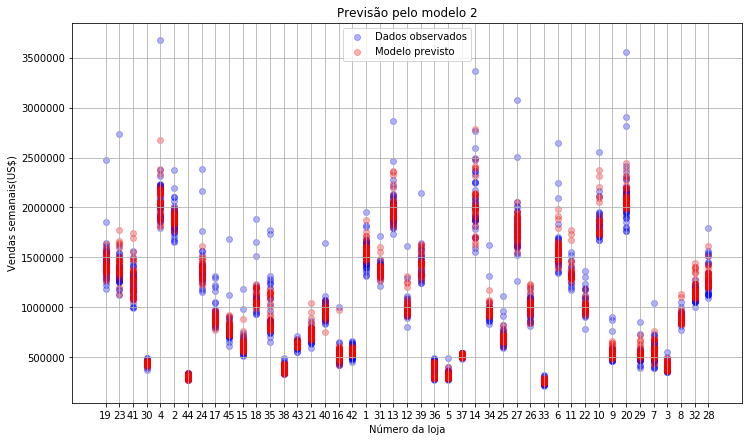

In [67]:
plt.figure(figsize=(12,7))
plt.title('Previsão pelo modelo 2')
plt.scatter(X_test.store, y_test, alpha='0.3', color='blue', label='Dados observados')
plt.scatter(X_test.store, resultado_final, alpha='0.3', color='red', label='Modelo previsto')
plt.xlabel('Número da loja')
plt.ylabel('Vendas semanais(US$)')
plt.legend()
plt.grid(True);

Portanto, já que o modelo 1 não obteve resultados satisfatórios de validação, buscou-se por um modelo que satisfizesse melhor a predição da variável target. Sendo assim, os melhores resultados foram obtidos com o uso do modelo de Random Forest Regression, o qual obteve um $R^2$ maior que 0,85 e um RMSE menor que o obtido pelo modelo de regressão linear múltipla. 


Além disso, plotou-se também um gráfico para analisar como o modelo iria prever as vendas semanais por loja.


Deste modo, tendo em posse a análise dos parâmetros e do gráfico, pode-se concluir que esse modelo serve bem para prever a variável target, uma vez que tem-se um $R^2$ bastante alto, um RMSE razoável e analisando o gráfico de dispersão, percebe-se uma boa proximidade entre o modelo previsto e os dados observados. 


#### Rascunhos

In [93]:
# Se estiver utilizando um software offline, biblioteca plotly deve ser instalada com o seguinte comando no terminal:
# pip install plotly==4.12.0
import plotly
import plotly.offline as py
from plotly.offline import plot, iplot
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)


# Define uma variável chamada Y que é a cópia da série de dados:
Y = df_teste.sort_values('date').weeklysales

# Define a variável window = 2 que será a janela de 2 valores:
window = 2

# Obtém os 2 primeiros valores da série:
history = []
for i in range(window):
    history.append(Y.iloc[i])

# Obtém todos os valores após os 2 primeiros:
teste_j = []
for i in range(window, len(Y)):
    teste_j.append(Y.iloc[i])

# Cria lista de predições:
predicoes_j = []

# Percorre sobre os dados de treinamento...

for t in range(len(teste_j)):
    # Define a variável length com o tamanho da variável history:
    length = len(history)
    
    # Define a variável valor_predito com a média dos 2 valores correntes..
    valor_predito = []
    for i in range(length - window, length):
        valor_predito.append(history[i])
    valor_predito = np.mean(valor_predito)
    
    # Define a variável valor_real com o valor atual do teste..
    valor_real = teste_k[t]
    
    # Alimenta a lista de predições:
    predicoes_j.append(valor_predito)
    # Atualiza a lista history com os valores correntes..
    history.append(valor_real)
    

# Calcula a métrica de rms:
rms_j = np.sqrt(mean_squared_error(teste_j, predicoes_j))
# Imprime o valor de rms:
print('RMS desse modelo: %.3f' % rms_j)

r_sqr_j = r_squared(list(teste_j),list(predicoes_j))
print(f'r quadrado do modelo de médias móveis: {r_sqr_j:.5f}')

indices = [i for i in range(0, int(len(teste_j)))]
teste = go.Scatter(x=indices,y=teste_j,name = "Conjunto de teste",line = dict(color = '#330000'),opacity = 0.8)
MM_2 = go.Scatter(x=indices,y=predicoes_j,name = "Média Móvel 2 Períodos",line = dict(color = '#FF00FF'),opacity = 0.8)
data = [teste, MM_2]
layout = dict(title = "Teste set vs Média Móvel 2 períodos",title_x= 0.5)
fig = dict(data=data, layout=layout)
py.iplot(fig)

RMS desse modelo: 676626.067
r quadrado do modelo de médias móveis: -0.45207


In [0]:
# Comparação e discussão dos resultados

## - Conclusão -

## - Referências Bibliográficas -

* https://d1wqtxts1xzle7.cloudfront.net/41933645/FORECAST_OF_SALES_OF_WALMART_STORE_USING_BIG_DATA_APPLICATIONS.pdf?1454491981=&response-content-disposition=inline%3B+filename%3DFORECAST_OF_SALES_OF_WALMART_STORE_USING.pdf&Expires=1605614440&Signature=DPer3zvFl7B5EM46LJWPgYXscJNdxbzVCfa308NyoF6sU9ydieGyJ0wbXUYIkQ5l9GWfB8d1GciSQtJPGLAwgjCWJ2f5267cw~gdIlOPukMk~TeRzlDOdRlIZJ~v2u6kUL0J0AlpLZZEgLIsFtJMwgeSrdCPuXGjIH67jWaTNEJxLuPRc70jIoita-hdS7n2HF1uSmHok7tUWeJVvAhMxqT~vZ-XKuJMb8OTGCkyhwVazQJ7RpwR406ffqcOST4aDrioWlof4iW~hXYQbtWBoHg-l4pSll8jD7EnhkHm3jxqz-L2soAs4KeCxC7Vjzk6PPvnH4nmtRxKqM~imc8auw__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA

* https://www.lume.ufrgs.br/bitstream/handle/10183/147496/000999425.pdf?sequence=1

* http://prcrepository.org:8080/xmlui/bitstream/handle/20.500.12475/174/FA-19_Articulo%20Final_Jose%20Santaella.pdf?sequence=1

* https://www.cse.scu.edu/~mwang2/projects/ML_KaggleM5Forecasting_20s.pdf

* https://medium.com/datadriveninvestor/walmart-sales-data-analysis-sales-prediction-using-multiple-linear-regression-in-r-programming-adb14afd56fb

* https://medium.com/datadriveninvestor/random-forest-regression-9871bc9a25eb

* https://ensinandomaquinasblog.wordpress.com/2017/12/15/modelos-preditivos-de-notas-de-redacao-do-enem-2015/

* https://minerandodados.com.br/prevendo-dados-com-janelas-deslizantes-usando-python/

* https://medium.com/datadriveninvestor/k-fold-cross-validation-6b8518070833

* https://paulovasconcellos.com.br/como-saber-se-seu-modelo-de-machine-learning-est%C3%A1-funcionando-mesmo-a5892f6468b

* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

* https://minerandodados.com.br/prevendo-a-demanda-de-alugueis-de-bicicletas-com-machine-learning/

* https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html 

* https://medium.com/swlh/random-forest-and-its-implementation-71824ced454f 

Commit:
    
Membros: Andressa, Camila, Luiz, Matheus